## Pairs Trading Project
1. Assume that you have USD \$100,000 to Trade Coke and Pepsi
2. Interest rate is 5% annually
3. On the 29th of December 2023, at the close of the market, assume you short sell USD \$100,000 shares of Coke stock, use the proceeds to buy USD $100,000 shares of Pepso.
4. Simulate 1,000,000 daily paths of the pairs trade for the next 6 months. Be explicit with all the assumptions you make on the random walks you generate and how you think about their correlation and mean-reversion
5. If we enter the trade on the 9th what is the expected value of the trade on the 16th? What is the 5th and 95th percentile profit-loss?
At what price differential would you eneter this pairs trade, at what price would you exit? Why?



## First let's load the data for Pepsi and Coke for the last 5 years

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import matplotlib.dates as mdates
import scipy.stats as stats
from numpy.linalg import cholesky
import sklearn as sk
from sklearn.linear_model import LinearRegression

df = pd.read_csv('/content/drive/MyDrive/Numeric/BookKOPEP.csv')

df = df.dropna(axis=1, how='all')

# Since Spread can be negative prior to 2019 we will consider data from 2019
# Defining the date range
start_date = '2019-01-01'
end_date = '2023-12-29'

# Select rows within the date range
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Display the combined data
print(df)

            Date     KO     PEP
7307  2019-01-02  39.25   92.70
7308  2019-01-03  39.01   91.84
7309  2019-01-04  39.79   93.72
7310  2019-01-07  39.27   92.91
7311  2019-01-08  39.71   93.81
...          ...    ...     ...
8560  2023-12-22  57.02  163.86
8561  2023-12-26  57.26  165.01
8562  2023-12-27  57.40  165.54
8563  2023-12-28  57.44  165.53
8564  2023-12-29  57.62  165.97

[1258 rows x 3 columns]


Coefficient: 3.3184776725709493


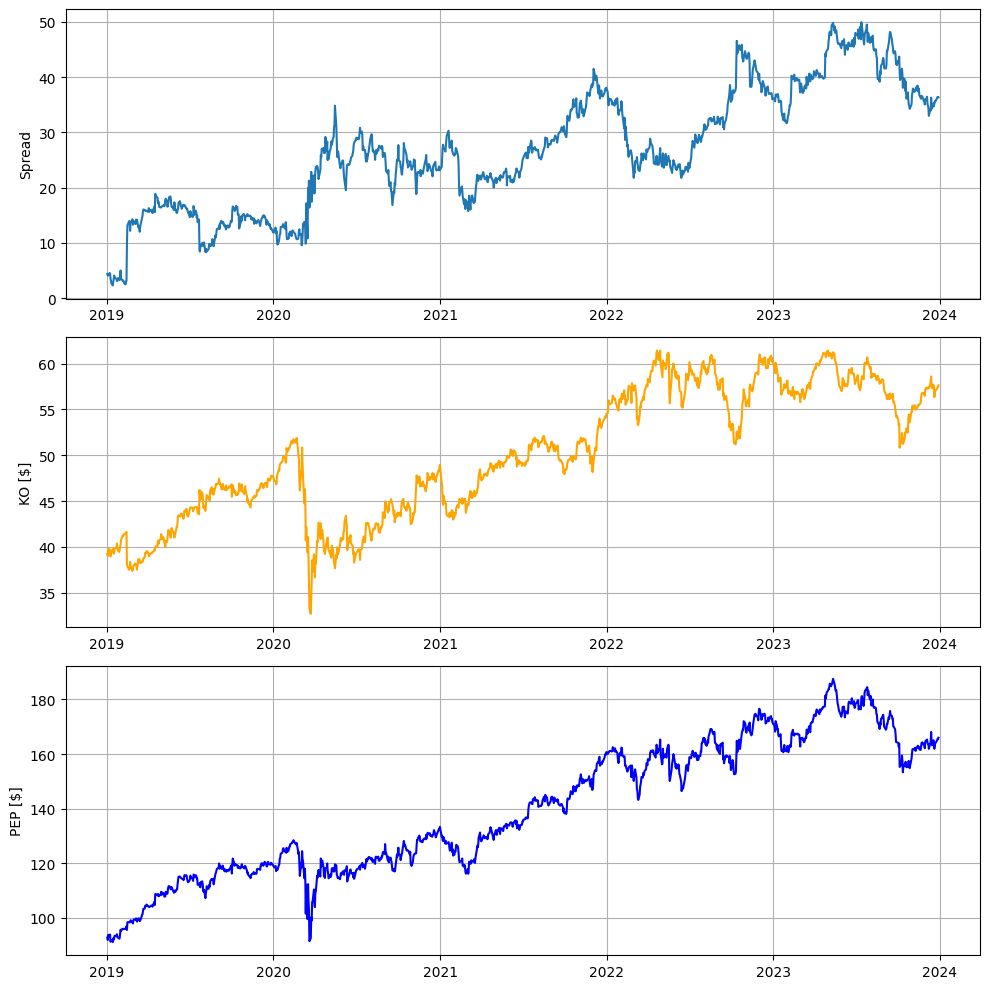

In [ ]:
# Extract the time and data columns from the dataframe
t = pd.to_datetime(df['Date'])

# Extract the KO and PEP columns
ko = df['KO']
pep = df['PEP']

dKO = np.diff(ko)
rKO = np.diff(ko) / ko[:-1]

dPEP = np.diff(pep)
rPEP = np.diff(pep) / pep[:-1]

# Perform regression of PEP on KO using scikit-learn
model = LinearRegression()

# Fit the model
model.fit(ko.values.reshape(-1, 1), pep)

print(f"Coefficient: {model.coef_[0]}")

# then we choose a number less than that so we don't get negative numbers
spread = pep - 2.25 * ko

# Set up the figure
plt.figure(figsize=(10, 10))

# First subplot: PEP - KO spread
plt.subplot(3, 1, 1)
plt.plot(t, spread, label="Spread")
plt.ylabel('Spread')
plt.grid(True)

# Second subplot: KO prices
plt.subplot(3, 1, 2)
plt.plot(t, ko, label="KO", color="orange")
plt.ylabel('KO [$]')
plt.grid(True)

# Third subplot: PEP prices
plt.subplot(3, 1, 3)
plt.plot(t, pep, label="PEP", color="blue")
plt.ylabel('PEP [$]')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()

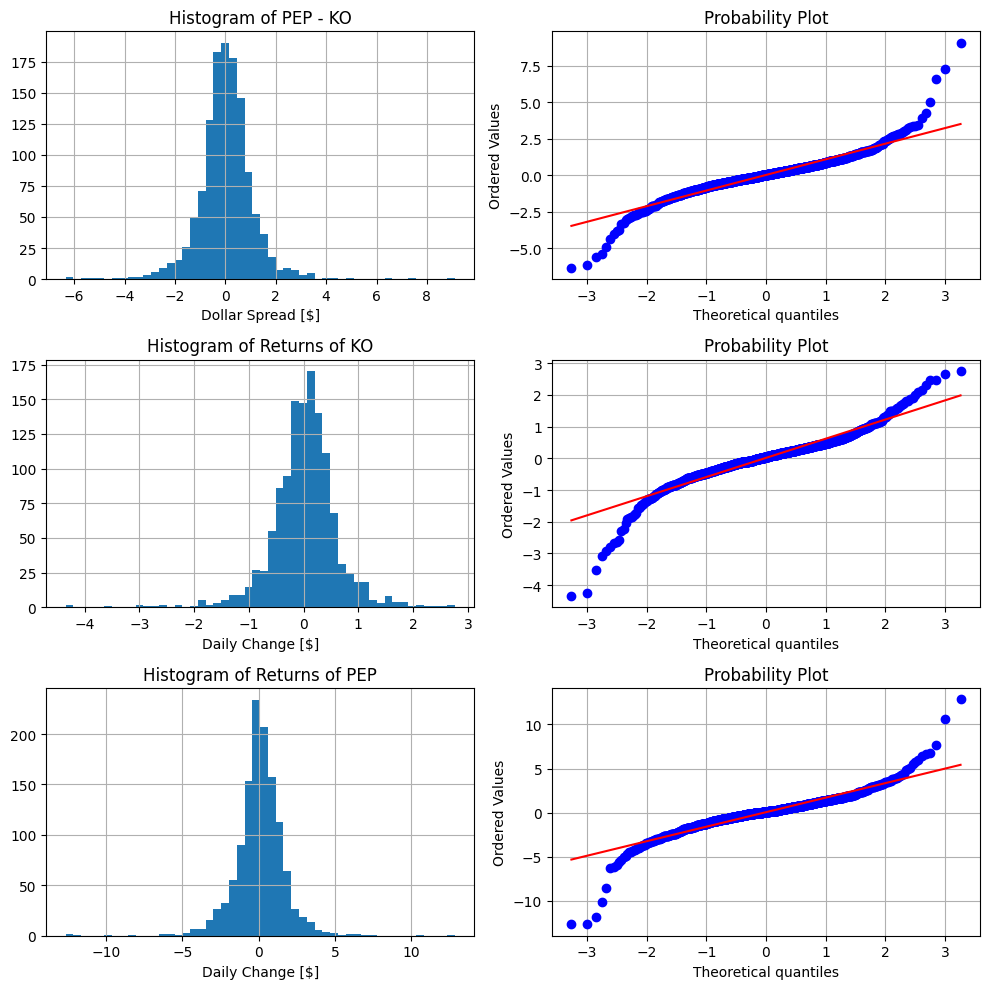

In [ ]:
# Calculate daily differences (delta)
dSpread = np.diff(spread) # difference in spread
rSpread = np.diff(spread) / spread[:-1] # percentage change in spread

dKO = np.diff(ko) # difference in coke price
rKO = np.diff(ko) / ko[:-1] # percentage change in coke price

dPEP = np.diff(pep)
rPEP = np.diff(pep) / pep[:-1]

# Set up the figure
plt.figure(figsize=(10, 10))

# First subplot: Histogram of PEP - KO spread
plt.subplot(3, 2, 1)
plt.hist(dSpread, bins=50)
plt.grid(True)
plt.title('Histogram of PEP - KO')
plt.xlabel('Dollar Spread [$]')

# Second subplot: Q-Q plot for PEP - KO spread
plt.subplot(3, 2, 2)
stats.probplot(dSpread, dist="norm", plot=plt)
plt.grid(True)

# Third subplot: Histogram of KO returns
plt.subplot(3, 2, 3)
plt.hist(dKO, bins=50)
plt.grid(True)
plt.title('Histogram of Returns of KO')
plt.xlabel('Daily Change [$]')

# Fourth subplot: Q-Q plot for KO returns
plt.subplot(3, 2, 4)
stats.probplot(dKO, dist="norm", plot=plt)
plt.grid(True)

# Fifth subplot: Histogram of PEP returns
plt.subplot(3, 2, 5)
plt.hist(dPEP, bins=50)
plt.grid(True)
plt.title('Histogram of Returns of PEP')
plt.xlabel('Daily Change [$]')

# Sixth subplot: Q-Q plot for PEP returns
plt.subplot(3, 2, 6)
stats.probplot(dPEP, dist="norm", plot=plt)
plt.grid(True)

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

## Simulating stock prices of PEP, KO, and Spread. Overlay the actual data
We checked the normality of historical data, then we want to calculate PEP and KO and spread mean and standard deviation, and simulated based on normal assumptions.  

In [ ]:
# set seed
np.random.seed(1006787700)

# Parameters
NTrials = 10000
T = 1  # 1 year
NSteps = 1258  # number of trading

dt = T / NSteps

# Model KO (Coke)
# we find mean and standard deviation from our historical data, and assuming
# price distribution is normal we simulate it based on the mu and sigma we found
mu_ko = np.mean(dKO)
sigma_ko = np.std(dKO)

U_ko = np.random.rand(NSteps, NTrials)
Z_ko = norm.ppf(U_ko)  # this gives the standard deviation
Xo_ko = ko.values.reshape(-1, 1)[0]

# here we use cumsum because mu_ko is the difference between stock prices each
# day, i.e.; the daily price difference
Xko = Xo_ko + np.cumsum(mu_ko + sigma_ko * Z_ko, axis=0)

# Model PEP (Pepsi)
# we do the same thing for Pepsi
mu_pep = np.mean(dPEP)
sigma_pep = np.std(dPEP)

U_pep = np.random.rand(NSteps, NTrials)
Z_pep = norm.ppf(U_pep)
Xo_pep = pep.values.reshape(-1,1)[0]

Xpep = Xo_pep + np.cumsum(mu_pep + sigma_pep * Z_pep, axis=0)

# Model the Spread (PEP - KO)
# we do the same thing for spread
mu_spread = np.mean(dSpread)
sigma_spread = np.std(dSpread)

U_spread = np.random.rand(NSteps, NTrials)
Z_spread = norm.ppf(U_spread)
Xo_spread = spread.values.reshape(-1,1)[0]

X_spread = Xo_spread + np.cumsum(mu_spread + sigma_spread * Z_spread, axis=0)


# # Plotting
# plt.figure(figsize=(15, 5))

# # Subplot 1: Coke
# plt.subplot(1, 4, 1)
# plt.plot(t, Xko)
# plt.title('Coke')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.grid(True)

# # Overlay actual Coke data
# plt.plot(t[:len(ko)], ko, 'ko', markersize=1)
# plt.ylim([-300, 400])

# # Subplot 2: Pepsi
# plt.subplot(1, 4, 2)
# plt.plot(t, Xpep)
# plt.title('Pepsi')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.grid(True)

# # Overlay actual Pepsi data
# plt.plot(t[:len(pep)], pep, 'ko', markersize=1)
# plt.ylim([-300, 400])

# # Subplot 3: Actual Spread
# # this is based on simulating on the spread
# plt.subplot(1, 4, 3)
# plt.plot(t, X_spread)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.grid(True)

# # Overlay actual spread data
# plt.plot(t[:len(spread)], spread, 'ko', markersize=1)
# plt.ylim([-300, 400])
# plt.title('Spread Actual')

# # Subplot 4: Uncorrelated Spread (PEP - KO)
# # this is the simulated spread where we plot the spread between the simulated
# # Pepsi price and coke price
# plt.subplot(1, 4, 4)
# plt.plot(t, Xpep - 2.25 * Xko)
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.grid(True)

# # Overlay actual spread data
# plt.plot(t[:len(spread)], spread, 'ko', markersize=1)
# plt.ylim([-300, 400])
# plt.title('Spread Uncorrelated')

# # Adjust layout and display
# plt.tight_layout()
# plt.show()

## Simulating correlated random variable
Which this starts with generating standard normal variables,
Then we use the Cholesky decomposition of the desires correlation matrix to transform these independent variables into correlated variables

Note that Cholesky only works for independent normal variables.

In [ ]:
# Generate random uniform variables

u1 = np.random.rand(NSteps, NTrials)
u2 = np.random.rand(NSteps, NTrials)

# Transform uniform variables to normal (standard normal) using inverse CDF (ppf in scipy)
w1 = norm.ppf(u1)
w2 = norm.ppf(u2)

# Calculate the target correlation matrix based on the daily changes in PEP and KO
C = np.corrcoef(dPEP, dKO)


## What is the difference between Cholesky and Wieners, which one do we use?

So here we actually used a uniform distribution, then used the normal inverse cdf to find the z-score, which we do this to get two independent normal random variables.

Then we compute the correlation matrix between pepsi and Coke, and use Cholesky decomposition for transformation, then put it in a wiener's process to get a correlated wiener's process.

In [ ]:
# Find the Cholesky Decomposition (upper triangle)
L = cholesky(C).T  # Transpose to get the upper triangle

# Initialize z1 and z2 to zeros, matching the size of w1 and w2
z1 = np.zeros_like(w1)
z2 = np.zeros_like(w2)

# Loop over each trial and correlate the Wiener processes
for i in range(NTrials):
    zTemp = np.dot(np.column_stack((w1[:, i], w2[:, i])), L)
    z1[:, i] = zTemp[:, 0]
    z2[:, i] = zTemp[:, 1]

# You can check the correlation of the first trial as an example
corr = np.corrcoef(z1[:, 0], z2[:, 0])

print("Correlation coefficient for the first trial:", corr)

Correlation coefficient for the first trial: [[1.         0.77569565]
 [0.77569565 1.        ]]


In [ ]:
mu = [np.mean(dPEP), np.mean(dKO)]
mu

[0.0582895783611774, 0.014614160700079553]

In [ ]:
sigma = [np.std(dPEP), np.std(dKO)]
sigma

[1.7475134334688018, 0.6319231282287469]

In [ ]:
# # Initial values for Pepsi and Coke (first data points)
# Xo = [pep.values.reshape(-1,1)[0], ko.values.reshape(-1,1)[0]]

# # Cumulative sum to generate the paths for Pepsi and Coke
# # these z1 and z2 are z-scores found from the correlated wiener process
# XXpep = Xo[0] + np.cumsum(mu[0] + sigma[0] * z1, axis=0)
# XXko = Xo[1] + np.cumsum(mu[1] + sigma[1] * z2, axis=0)

# # Calculate the spread between Pepsi and Coke
# XXSpread = XXpep - 2.25 * XXko

# # Plotting the results
# plt.figure(figsize=(15, 5))

# # Subplot 1: Actual based on mu and sigma and a normal distr.
# plt.subplot(1, 3, 1)
# plt.plot(t, X_spread, label='Simulated Spread')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.grid(True)
# plt.title('Actual')

# # Overlay actual spread data
# plt.plot(t[:len(spread)], spread, 'ko', markersize=2)
# plt.ylim([-300, 400])

# # Subplot 2: Uncorrelated
# plt.subplot(1, 3, 2)
# plt.plot(t, Xpep - 2.25 * Xko, label='Uncorrelated Spread')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.grid(True)
# plt.title('Uncorrelated')

# # Overlay actual spread data
# plt.plot(t[:len(spread)], spread, 'ko', markersize=2)
# plt.ylim([-300, 400])

# # Subplot 3: Correlated
# plt.subplot(1, 3, 3)
# plt.plot(t, XXSpread, label='Correlated Spread')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# plt.grid(True)
# plt.title('Correlated')

# # Overlay actual spread data
# plt.plot(t[:len(spread)], spread, 'ko', markersize=2)
# plt.ylim([-300, 400])

# # Adjust layout and display
# plt.tight_layout()
# plt.show()

## Forecasting:
What we are doing here is just to start from the stock price of the last day, then simulate based on the brownian motion we simulated earlier and so basically we should have simulated paths from Dec. 29 to the next 131 trading days.


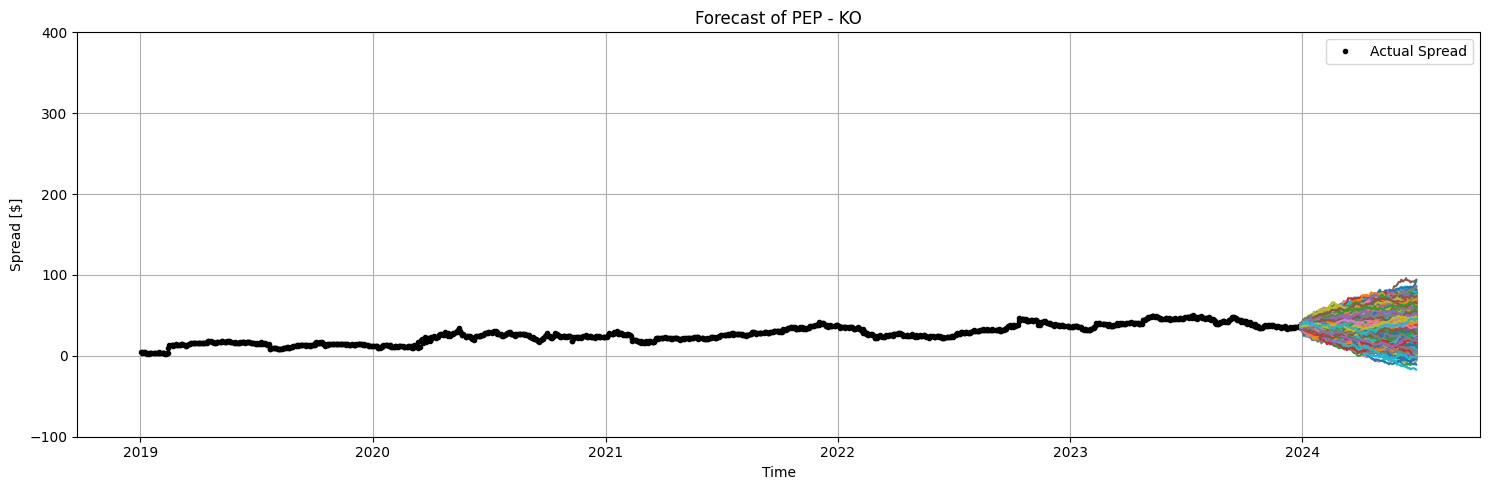

In [ ]:
# Step 1: Define the last prices of Pepsi and Coke as the starting points for forecasting
Xo = [pep[8564], ko[8564]]  # Last prices of Pepsi and Coke

ndays= 131

# Step 2: Build forecast for Pepsi and Coke prices using cumulative sum (cumsum)
XXpepForecast = Xo[0] + np.cumsum(mu[0] + sigma[0] * z1[-ndays :, :], axis=0)
XXkoForecast = Xo[1] + np.cumsum(mu[1] + sigma[1] * z2[-ndays :, :], axis=0)

# Step 3: Calculate the forecasted spread between Pepsi and Coke
XXSpreadForecast = XXpepForecast - 2.25 * XXkoForecast

# Step 4: Create a forecast time vector starting from the last time point

tForecast = pd.date_range(start=t[8564], periods = ndays, freq = "B")

# Step 5: Plotting the historical and forecasted spread

plt.figure(figsize=(15, 5))

# Plot the actual spread
plt.plot(t, spread, 'ko', markersize=3, label='Actual Spread')

# Plot the forecasted spread
plt.plot(tForecast, XXSpreadForecast)

# Format the x-axis to show the year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set plot limits and labels
plt.ylim([-100, 400])
plt.grid(True)
plt.title('Forecast of PEP - KO')
plt.xlabel('Time')
plt.ylabel('Spread [$]')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

## Better Visualization
Let's zoom in on the forecasts

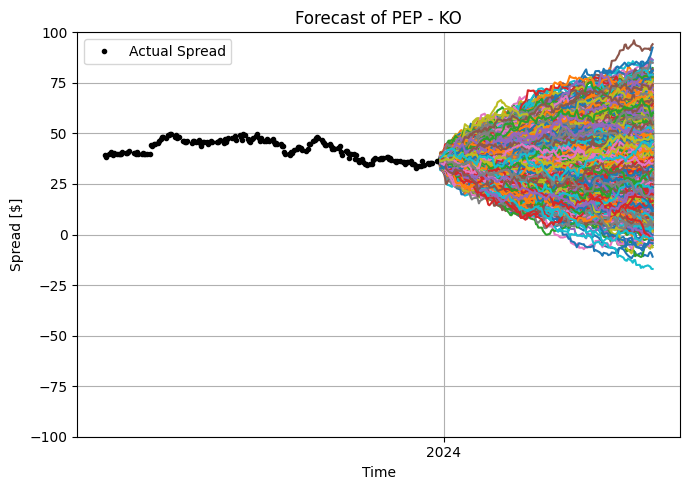

In [ ]:
t_adjust = t[-200:]
spread_adjust = spread[-200:]

plt.figure(figsize=(7, 5))

# Plot the actual spread
plt.plot(t_adjust, spread_adjust, 'ko', markersize=3, label='Actual Spread')

# Plot the forecasted spread
plt.plot(tForecast, XXSpreadForecast)

# Format the x-axis to show the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set plot limits and labels
plt.ylim([-100, 100])
plt.grid(True)
plt.title('Forecast of PEP - KO')
plt.xlabel('Time')
plt.ylabel('Spread [$]')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Mean Reverting Process for the Spread

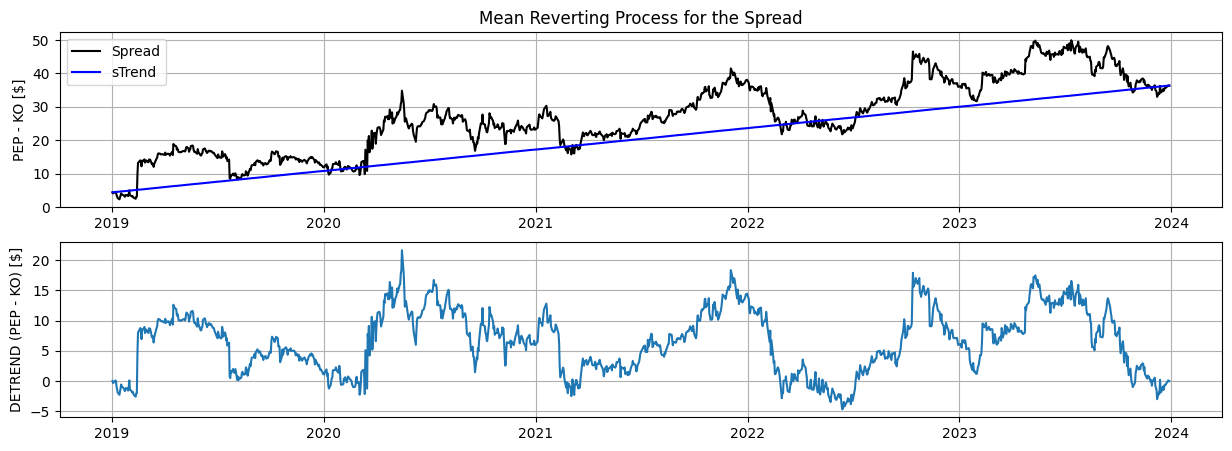

In [ ]:
# we want to first find the trend component of these simulations
NSteps = len(spread)
sTrend = spread[7307] + np.mean(dSpread) * np.linspace(0, NSteps, NSteps)

# then we find the detrended spread

de_spread = spread - sTrend
d_de_spread = np.diff(de_spread)

# first we plot the Trend and spread
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.plot(t, spread, 'k-', label='Spread')  # Black line for Spread
plt.plot(t, sTrend, 'b-', label='sTrend')  # Blue line for sTrend
plt.ylabel('PEP - KO [$]')
plt.title('Mean Reverting Process for the Spread')
plt.grid(True)
plt.legend()
# now let's plot the

plt.subplot(2, 1, 2)

# Note: We need to adjust length for diff, so we adjust time by 1
plt.plot(t, de_spread, label='Detrended Spread')
plt.ylabel('DETREND (PEP - KO) [$]')
plt.grid(True)


##Using OU process to model Mean Reversion

<ipython-input-15-57ef5c20690d>:56: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


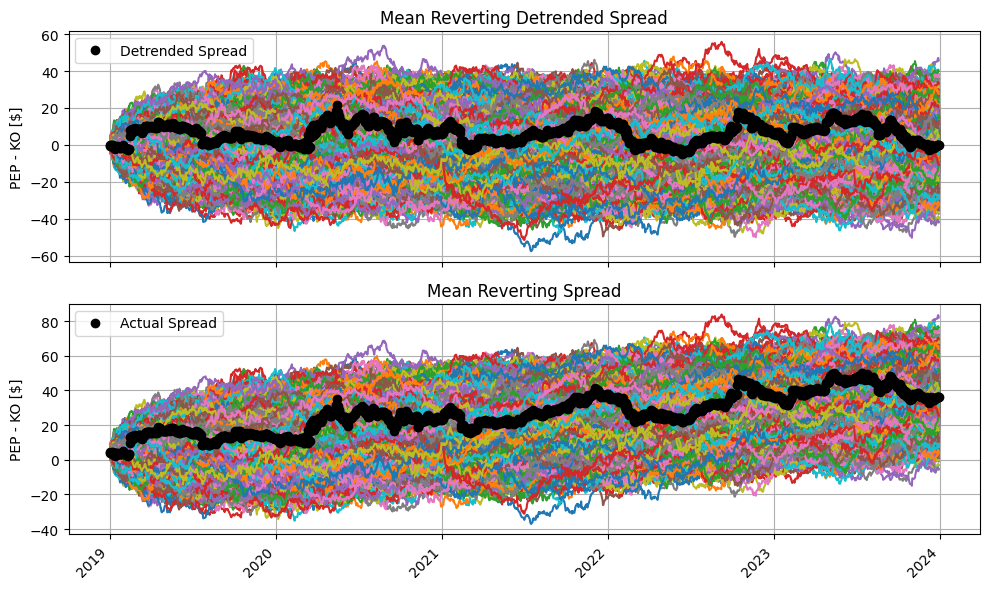

In [ ]:
from scipy.stats import norm

# Step 1: Model parameters
mu = np.mean(d_de_spread)
sigma = np.std(d_de_spread)

# Generate random samples from a normal distribution
U = np.random.rand(NSteps, NTrials)
Z = norm.ppf(U)  # Equivalent to MATLAB's norminv

# Initial condition for Xo (first value of spreadDetrend)

Xo = de_spread[7307]

# Step 2: Initialize OU process array
XOU = np.zeros((NSteps, NTrials))
XOU[0, :] = Xo

# Mean reversion rate
a = 0.005

# Step 3: Simulate the OU process
for i in range(1, NSteps):
    XOU[i, :] = XOU[i - 1, :] + mu - a * XOU[i - 1, :] + sigma * Z[i, :]

# Add back the trend to get the overall process
XOUTREND = XOU + sTrend[:, np.newaxis]  # Make sure sTrend matches shape

# Step 4: Plotting

plt.figure(figsize=(10, 6))  # Equivalent to 'Position' in MATLAB

# First subplot: Mean Reverting Detrended Spread (XOU vs. spreadDetrend)
plt.subplot(2, 1, 1)
plt.plot(t, XOU)  # Plot the OU process
plt.plot(t, de_spread, 'ko', label='Detrended Spread')  # Plot actual detrended spread
plt.title('Mean Reverting Detrended Spread')
plt.ylabel('PEP - KO [$]')
plt.grid(True)
plt.legend()

# Second subplot: Mean Reverting Spread (XOUTREND vs. spread)
plt.subplot(2, 1, 2)
plt.plot(t, XOUTREND)  # Plot OU process with trend
plt.plot(t, spread, 'ko', label='Actual Spread')  # Plot actual spread
plt.title('Mean Reverting Spread')
plt.ylabel('PEP - KO [$]')
plt.grid(True)
plt.legend()

# Format x-axis as dates
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


##Forecasting with Mean Reverting

<Figure size 1000x600 with 0 Axes>

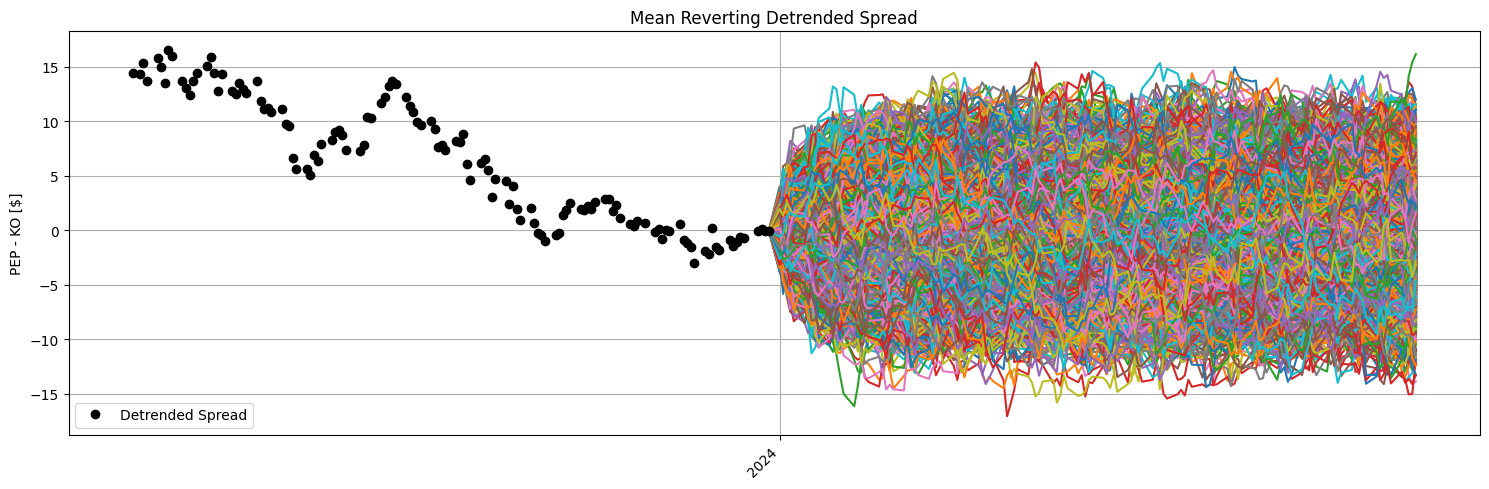

In [ ]:
from scipy.stats import norm

# Step 1: Set Nstep and NTrials(For now let's consider 100)
NSteps = 131
NTrials = 10000

# Generate random samples from a normal distribution
U = np.random.rand(NSteps, NTrials)
Z = norm.ppf(U)

# Initial condition for Xo (Last value of spreadDetrend)

Xo = de_spread[8564]

# Step 2: Initialize OU process array
XOU = np.zeros((NSteps, NTrials))
XOU[0, :] = Xo

# Mean reversion rate
a = 0.05

# Step 3: Simulate the OU process
for i in range(1, NSteps):
    XOU[i, :] = XOU[i - 1, :] + mu - a * XOU[i - 1, :] + sigma * Z[i, :]

# Step 4: Plotting
t2 = t[-126:]

plt.figure(figsize=(10, 6))  # Equivalent to 'Position' in MATLAB

# First subplot: Mean Reverting Detrended Spread (XOU vs. spreadDetrend)
plt.figure(figsize = (15,5))
plt.plot(tForecast, XOU)  # Plot the OU process
plt.plot(t2, de_spread[-126:], 'ko', label='Detrended Spread')  # Plot actual detrended spread
plt.title('Mean Reverting Detrended Spread')
plt.ylabel('PEP - KO [$]')
plt.grid(True)
plt.legend()

# Format x-axis as dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Calculating the value of the trade on Jan. 31th 2024 & Jun. 30th 2024

I will use the correlation method to calculate the value of trade

In [ ]:
# get the price of coke stock on December 29th 2023
Ko_Price = ko[8564]

# get the price of Pepsi on December 29th 2023
Pep_price = pep[8564]

# we will assume fractions of shares are possible
cash = 100000
num_shares_ko = cash / Ko_Price
num_shares_pep = cash / Pep_price

# Get time stamp for these two trading days
Jan_time = pd.Timestamp('2024-01-31')
Jan_index = tForecast.get_loc(Jan_time)

Jun_time = pd.Timestamp('2024-06-28')
print(tForecast)
Jun_index = tForecast.get_loc(Jun_time)

# Get the price on Jan. 31 2024
pep_jan = np.mean(XXpepForecast[Jan_index])
ko_jan = np.mean(XXkoForecast[Jan_index])

# Get the price on Jun. 28 2024
pep_jun = np.mean(XXpepForecast[Jun_index])
ko_jun = np.mean(XXkoForecast[Jun_index])

# Let's find the trading result on Jan. 31 2024 and find present value to Dec. 29 2024
date_1 = pd.Timestamp('2023-12-29')
date_2 = pd.Timestamp('2024-01-31')
date_3 = pd.Timestamp('2024-06-28')
Jan_port_val = (num_shares_pep * pep_jan - num_shares_ko * ko_jan) / (1+0.05)**((date_2 - date_1).days / 365)

Jun_port_val = num_shares_pep * pep_jun - num_shares_ko * ko_jun / (1 + 0.05)**((date_3 - date_1).days / 365)

print(f'The present value of the trade on Jan. 31th 2024 is {Jan_port_val}')
print(f'The present value of the trade on Jun. 30th 2024 is {Jun_port_val}')


DatetimeIndex(['2023-12-29', '2024-01-01', '2024-01-02', '2024-01-03',
               '2024-01-04', '2024-01-05', '2024-01-08', '2024-01-09',
               '2024-01-10', '2024-01-11',
               ...
               '2024-06-17', '2024-06-18', '2024-06-19', '2024-06-20',
               '2024-06-21', '2024-06-24', '2024-06-25', '2024-06-26',
               '2024-06-27', '2024-06-28'],
              dtype='datetime64[ns]', length=131, freq='B')
The present value of the trade on Jan. 31th 2024 is 243.2001062807972
The present value of the trade on Jun. 30th 2024 is 3686.4189483915106


## Results
The value of the trade on Jan. 31th 2024 is 184.00270049177925

The value of the trade on Jun. 30th 2024 is 1499.2863361329946

## 5th and 95th percentile of profit and losses.


In [ ]:
# first we find the profits:
Jan_values = num_shares_pep * XXpepForecast[Jan_index] - num_shares_ko * XXkoForecast[Jan_index]
Jun_values = num_shares_pep * XXpepForecast[Jun_index] - num_shares_ko * XXkoForecast[Jun_index]

# Then we sort the data:
Jan_sorted = np.sort(Jan_values)
Jun_sorted = np.sort(Jun_values)


# find the 5th percentile for Jan:
five_Jan = Jan_sorted[int(0.05 * len(Jan_sorted))]

#find the 95th percentile for Jan:
ninety_five_Jan = Jan_sorted[int(0.95 * len(Jan_sorted))]

#find the 5th percentile for Jun:
five_Jun = Jun_sorted[int(0.05 * len(Jun_sorted))]

#find the 95th percentile for Jun:
ninety_five_Jun = Jun_sorted[int(0.95 * len(Jun_sorted))]

print(f'The 5th percentile of pep in Jan is {five_Jan}')
print(f'The 95th percentile of pep in Jan is {ninety_five_Jan}')
print(f'The 5th percentile of pep in Jun is {five_Jun}')
print(f'The 95th percentile of pep in Jun is {ninety_five_Jun}')



The 5th percentile of pep in Jan is -5664.545232683522
The 95th percentile of pep in Jan is 6146.85213101728
The 5th percentile of pep in Jun is -12512.23489521131
The 95th percentile of pep in Jun is 15431.839309028946


## Results
The 5th percentile of pep in Jan is -5664.545232683522

The 95th percentile of pep in Jan is 6146.85213101728

The 5th percentile of pep in Jun is -12512.23489521131

The 95th percentile of pep in Jun is 15431.839309028946

## Optimal Enter and Exit time:
The price spread between Coke and Pepsi exhibits characteristics of a mean-reverting process.This suggests that once the spread deviates from its mean, in our case it is about 0, it tends to revert back over time.

If we consider the time when the spread becomes highly negative, it implied that Pepsi is underperfoming Coke, creating a potential buying opportunity for Pepsi and a shorting opportunity for Coke. Hence, our goal is to enter when the detrended spread is at its most negative value, just before it begins to revert back to zero.

In terms of Exit time, once the spread reverts and approaches the mean, the relationship between the two stocks normalizes. At this point, th overvaluation of Coke and undervaluation of Pepsi have corrected, and the opportunituy for further gains diminishes, and this should be our indication to exit to lock in our profit.

## But how do we capture the lowest spread?

Since capturing the lowest point is inherently difficult, we employ statistical measures to make this task systematic. One commonly used approach is to enter the trade when the spread falls below 2 standard deviations below the mean. Standard deviation of 2 should be a typical treshold as it indicates a rare, extreme condition—one that is highly likely to revert in the near future.